In [1]:
# 先知晓一下当前的目录地址
!pwd

/public/home/huyezhen


In [2]:
# 安装必要的程序包
!pip install --upgrade lalsuite -i https://mirrors.aliyun.com/pypi/simple

Looking in indexes: https://mirrors.aliyun.com/pypi/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 MB 2.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 2.2 MB/s eta 0:00:00 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.6/37.6 MB 2.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 738.7/738.7 kB 1.5 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 2.2 MB/s eta 0:00:00a 0:00:01
  Created wheel for ligo-segments: filename=ligo_segments-1.4.0-cp310-cp310-linux_x86_64.whl size=50883 sha256=7fa1ee17c6fddf52978e4557fdfa1c1d68b3a932638b24282dfca1985eb5df49
  Stored in directory: /root/.cache/pip/wheels/2e/5d/db/c86a355b5168d21331ca4cd1c11103eb03277b1bce0afd4532
Successfully built ligo-segments

[notice] A new release of pip is available: 24.3.1 -> 25.1
[notice] To update, run: pip install --upgrade pip


In [6]:
pip install --upgrade pip

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 2.1 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 24.3.1
    Uninstalling pip-24.3.1:
      Successfully uninstalled pip-24.3.1
Note: you may need to restart the kernel to use updated packages.


In [7]:
# 安装必要的程序包
!pip install --upgrade lalsuite -i https://mirrors.aliyun.com/pypi/simple

Looking in indexes: https://mirrors.aliyun.com/pypi/simple


In [8]:
# https://git.ligo.org/lscsoft/lalsuite/-/issues/300
import lal
lal.__version__

'7.6.1'

In [9]:
import torch
torch.__version__

'2.3.0'

In [16]:
# 把脚本里的所有关联的程序包、类、函数都 load 一下
from main import *
from utils import *

loss 0.0019, train acc 0.980, test acc 0.990
855.4 examples/sec on cuda


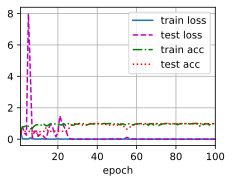

In [17]:
# 初始化数据生成 class
nsample_perepoch = 100  # 每个epoch的样本数
dataset_train = DatasetGenerator(snr=20, nsample_perepoch=nsample_perepoch)  # 训练数据集
dataset_test = DatasetGenerator(snr=20, nsample_perepoch=nsample_perepoch)  # 测试数据集

# 创建一个DataLoader
data_loader = DataLoader(dataset_train, batch_size=32, shuffle=True,)  # 训练数据加载器
test_iter = DataLoader(dataset_test, batch_size=32, shuffle=True,)  # 测试数据加载器

device = torch.device('cuda')  # 使用CUDA设备

# 模型和损失历史的输出路径
checkpoint_dir = './checkpoints_cnn/'

# 创建模型    
net, epoch, train_loss_history = load_model(checkpoint_dir)  # 加载模型
net.to(device);  # 将模型转移到设备上

# 优化器参数
lr = 0.003  # 学习率
total_epochs = 100  # 总的训练轮数
total_epochs += epoch  # 加上已经训练过的轮数
output_freq = 1  # 输出频率

# 训练模型
train(net, lr, nsample_perepoch, epoch, total_epochs,
      dataset_train, data_loader, test_iter,
      train_loss_history, checkpoint_dir, device, notebook=True)

In [18]:
dataset_train.strains.shape

(100, 1, 2, 16384)

In [20]:
!pip install scikit-learn -i https://mirrors.aliyun.com/pypi/simple/

Looking in indexes: https://mirrors.aliyun.com/pypi/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 3.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [scikit-learn] [scikit-learn]


In [21]:
import sklearn
print(sklearn.__version__)  # 查看版本号

1.6.1


In [23]:
# 加载必要的库
import lal  # https://git.ligo.org/lscsoft/lalsuite/-/issues/300
from main import *
from utils import *
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, roc_curve

def evaluate_gpu(net, data_iter, device=None):
    """使用GPU计算模型在数据集上的预测结果"""
    if isinstance(net, nn.Module):
        net.eval()  # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device  # 获取设备信息
    softmax = nn.Softmax(dim=-1)  # 定义softmax函数，dim=-1表示在最后一个维度上进行softmax运算
    y_hat_list = []  # 初始化预测结果列表
    y_list = []  # 初始化标签列表
    with torch.no_grad():  # 不进行梯度计算
        for X, y in data_iter:  # 遍历数据集
            X = X.to(device).to(torch.float)  # 将数据转移到设备上并转换为浮点型
            y = y.to(device).to(torch.long)  # 将标签转移到设备上并转换为长整型
            y_hat = net(X)  # 使用模型进行预测

            preds = softmax(y_hat).cpu().numpy()[:,1].tolist()  # 使用softmax函数处理预测结果，并转换为列表
            labels = y.cpu().numpy().tolist()  # 将标签转换为列表

            y_hat_list.extend(preds)  # 将预测结果添加到预测结果列表
            y_list.extend(labels)  # 将标签添加到标签列表
    return np.asarray(y_hat_list), np.asarray(y_list)  # 返回预测结果和标签的numpy数组```

In [24]:
nsample_perepoch = 1000 # num of injections
snr = 20  # 信噪比

dataset_test = DatasetGenerator(snr=snr, nsample_perepoch=nsample_perepoch)
data_iter = DataLoader(dataset_test, batch_size=32, shuffle=True,)

GPU available? True


In [25]:
# load model
device = torch.device('cuda')

# Where we output our model and loss history
checkpoint_dir = './checkpoints_cnn/'

# Creat model
net, epoch, train_loss_history = load_model(checkpoint_dir)
net.to(device);

Load network from checkpoints_cnn/model_e40.pt


In [26]:
y_hat_list, y_list = evaluate_gpu(net, data_iter, device)

In [27]:
fpr, tpr, thresholds = roc_curve(y_list, y_hat_list)
auc = roc_auc_score(y_list, y_hat_list)
auc

0.999424

In [28]:
index = np.argmax(thresholds < 0.5)

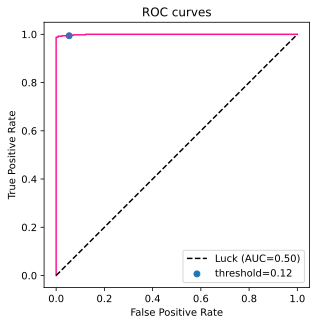

In [29]:
plt.plot(fpr, tpr, color="deeppink")
plt.plot(*(np.linspace(0,1,100),)*2, 'k--', label='Luck (AUC=0.50)')
plt.scatter(fpr[index], tpr[index], label=f'threshold={thresholds[index]:.2f}')
plt.axis("square")
# plt.xscale('log')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curves")
plt.legend()
plt.show()

100%|██████████| 4/4 [01:17<00:00, 19.33s/it]


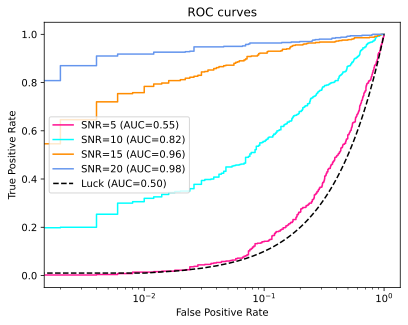

In [30]:
from itertools import cycle
colors = cycle(["deeppink", "aqua", "darkorange", "cornflowerblue"])

nsample_perepoch = 1000
snr_list = [5, 10, 15, 20]
for snr in tqdm(snr_list):
    dataset_test = DatasetGenerator(snr=snr, nsample_perepoch=nsample_perepoch, verbose=False)
    data_iter = DataLoader(dataset_test, batch_size=32, shuffle=True)
    y_hat_list, y_list = evaluate_gpu(net, data_iter, device)

    fpr, tpr, thresholds = roc_curve(y_list, y_hat_list)
    auc = roc_auc_score(y_list, y_hat_list)
    
    plt.plot(fpr, tpr, color=next(colors), label=f'SNR={snr} (AUC={auc:.2f})')
plt.plot(*(np.linspace(0,1,100),)*2, 'k--', label='Luck (AUC=0.50)')
# plt.axis("square")
plt.xscale('log')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curves")
plt.legend()
plt.show()

100%|██████████| 3/3 [00:58<00:00, 19.44s/it]


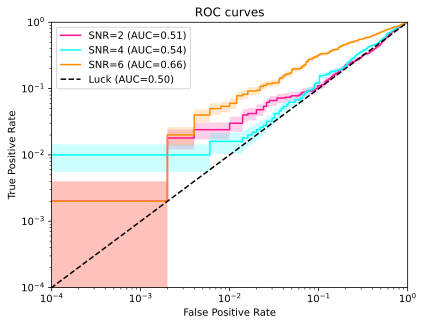

In [71]:
from itertools import cycle
colors = cycle(["deeppink", "aqua", "darkorange", "cornflowerblue"])

def sigma(n, tp):
    """

    :param tp:
    :param n:
    :return:
    """
    return np.sqrt(tp*(1.-tp)/n)

nsample_perepoch = 1000
snr_list = [2, 4, 6]
for snr in tqdm(snr_list):
    dataset_test = DatasetGenerator(snr=snr, nsample_perepoch=nsample_perepoch, verbose=False)
    data_iter = DataLoader(dataset_test, batch_size=32, shuffle=True)
    y_hat_list, y_list = evaluate_gpu(net, data_iter, device)

    fpr, tpr, _ = roc_curve(y_list, y_hat_list)
    auc = roc_auc_score(y_list, y_hat_list)
    
    fpr_error = [sigma(len(y_list)/2., t) for t in fpr]
    tpr_error = [sigma(len(y_list)/2., t) for t in tpr]
    
    color = next(colors)
    plt.plot(fpr, tpr, color=color, label=f'SNR={snr} (AUC={auc:.2f})')
    plt.fill_between(fpr, tpr+tpr_error, tpr-tpr_error, alpha=0.2, facecolor=color, zorder=0)
plt.plot(*(np.linspace(0,1,100),)*2, 'k--', label='Luck (AUC=0.50)')
# plt.axis("square")
plt.xscale('log')
plt.yscale('log')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curves")
plt.xlim(1e-4,1)
plt.ylim(1e-4,1)
plt.legend()
plt.show()

In [69]:
!bash gen_test_data.sh

bash: gen_test_data.sh: No such file or directory


In [70]:
import os
print(os.listdir())  # 列出当前目录的所有文件

['.bash_profile', '.mozilla', '.local', 'SothisAI', 'Untitled.ipynb', '__pycache__', 'test.npy', 'utils.py', '.emacs', '.bash_logout', '.bashrc', 'perl5', '.ssh', 'job_example', '.ai_user_info', '.jupyterLab', '.ipynb_checkpoints', 'main.py', 'baseline_sugon.ipynb', 'data_prep_bbh.py', 'checkpoints_cnn', '.Trash-0', 'ground_truth.csv', 'submission.csv']


In [50]:
import lal
import _pickle as pickle
from tqdm import tqdm
from main import *
from utils import *

In [65]:
sizeofeach = 100
groud_truth = []
test_dataset = []

for snr in tqdm([2,4,5,6,7,8,9,10,15,20,25,30]):
    test_data_addr = f'BBH_testing_1s_8192Hz_10Ksamp_25n_iSNR{snr}_Hdet_astromass_1seed_ts_0.sav'
    with open(test_data_addr, 'rb') as rfp:
        data = pickle.load(rfp)
        index = np.random.randint(len(data[1]), size=sizeofeach)

        groud_truth.extend(data[1][index].tolist())
        test_dataset.append(np.expand_dims(data[0][index], 1))
groud_truth = np.asarray(groud_truth)
test_dataset = np.concatenate(test_dataset)

groud_truth.shape, test_dataset.shape

  0%|          | 0/12 [00:00<?, ?it/s]


FileNotFoundError: [Errno 2] No such file or directory: 'BBH_testing_1s_8192Hz_10Ksamp_25n_iSNR2_Hdet_astromass_1seed_ts_0.sav'

In [54]:
import pandas as pd
pd.Series(groud_truth).value_counts()

Series([], Name: count, dtype: int64)

In [55]:
import pandas as pd
pd.DataFrame({'id': range(len(groud_truth)),
              'Public': groud_truth,
              'Usage': ('Public',)*len(groud_truth)}).to_csv('ground_truth.csv', index=False)

In [56]:
np.save('test', test_dataset)
# np.save('groud_truth', groud_truth)

In [ ]:
submission

In [58]:
import lal
import _pickle as pickle
from tqdm import tqdm
from main import *
from utils import *

def evaluate_submissoin_gpu(net, data_iter, device=None):
    """使用GPU计算模型在数据集上的预测结果"""
    if isinstance(net, nn.Module):
        net.eval()  # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device  # 获取设备信息
    softmax = nn.Softmax(dim=-1)  # 定义softmax函数，dim=-1表示在最后一个维度上进行softmax运算
    y_hat_list = []  # 初始化预测结果列表
    with torch.no_grad():  # 不进行梯度计算
        for X in data_iter:  # 遍历数据集
            X = X.to(device).to(torch.float)  # 将数据转移到设备上并转换为浮点型
            y_hat = net(X)  # 使用模型进行预测
            preds = softmax(y_hat).cpu().numpy()[:,1].tolist()  # 使用softmax函数处理预测结果，并转换为列表
            y_hat_list.extend(preds)  # 将预测结果添加到预测结果列表
    return y_hat_list

In [59]:
test_dataset = np.load('test.npy')
test_dataset.shape

(0,)

In [60]:
data_loader = DataLoader(test_dataset, batch_size=32, shuffle=False,)

In [61]:
# load model
device = torch.device('cuda')

# Where we output our model and loss history
checkpoint_dir = './checkpoints_cnn/'

# Creat model
net, epoch, train_loss_history = load_model(checkpoint_dir)
net.to(device);

Load network from checkpoints_cnn/model_e40.pt


In [62]:
results = evaluate_submissoin_gpu(net, data_loader, device)
len(results)

0

In [63]:
# results

In [64]:
import pandas as pd
pd.DataFrame({'id': range(len(results)),
              'target': results}, index=None).to_csv('submission.csv', index=False)